# Evaluation of GURK Models

Anina Klaus & Katja Konermann

Imports:

In [32]:
import ast
import json

import torch
from datasets import load_dataset, Dataset
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel, BertTokenizerFast, BertModel, BertTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

from gurk.modules import FullModel

In [33]:
config_path = "configs/run-02-params.json"
with open(config_path, "r") as config_f:
  params = json.load(config_f)

In [34]:
tokenizer = BertTokenizerFast.from_pretrained(params["tokenizer-model"])
tokenizer_data = BertTokenizerFast.from_pretrained("bert-base-cased")

In [35]:
model = FullModel(
            vocab_size=tokenizer.vocab_size,
            max_len=params["max_len"],
            **params["model_params"]
        )
checkpoint = torch.load("gurklm\jan11_fullrun_epoch4_step450954.pt", map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\HP I5\AppData\Local\Temp\ipykernel_15240\3544323.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("gurklm\jan11_fullrun_epoch4_step450954

<All keys matched successfully>

In this task, I will be using the tokenization function as provided in the assignment description:

In [36]:
def tokenize_and_align_labels(examples, label_all_tokens=False, skip_index=-100, label_name="upos"):
    tokenized_inputs = tokenizer_data(examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=256)
    labels = []

    for i, label in enumerate(examples[label_name]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids : list[int] = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(skip_index)

            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else skip_index)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

This tokenization function relies on a global variable named "tokenizer", which is set up in the following cell with the XLMRobertaTokenizer.

If GPU training is available, the device is selected accordingly in the following cell:

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

For subsequent dataset preparation, the batch siz will already be set up here, with a value of 16 items per batch.

In [38]:
BATCH_SIZE = 16

## Dataset preparation

In the following cell, the corpus is prepared for training and testing.

In [39]:
# Load dataset
ds = load_dataset("universal_dependencies", name="qtd_sagt")
train, val, test = ds.values()


# Tokenize
train_tokenized = train.map(lambda example: tokenize_and_align_labels(example),
                            batched=True, batch_size=BATCH_SIZE)

val_tokenized = val.map(lambda example: tokenize_and_align_labels(example),
                        batched=True, batch_size=BATCH_SIZE)

# Filter as needed for subsequent processing
train_tokenized.set_format(type='torch', columns=list(["input_ids",
                                                       "labels",
                                                       "attention_mask"]))
val_tokenized.set_format(type='torch', columns=list(["input_ids",
                                                     "labels",
                                                     "attention_mask"]))


# Create DataLoaders
train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_tokenized, batch_size=BATCH_SIZE)

c:\Users\HP I5\anaconda3\envs\gurk\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for universal_dependencies contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/universal_dependencies
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


A quick look at the data tells us that the trainig set consists of 13,814 sentences, the validation set of 799 sentences and the test set of 977 sentences. The sets contain a number of features, but to our task at hand only "tokens" and "upos" will be relevant.

### The tag set

The POS tags are to be found the "upos" feature of the dataset. They are, however, encoded as tag indices. The following function returns a dictionary to map them back.

In [40]:
def get_mapping(examples):
    """Get mapping of tag indices to human-readable tags."""
    upos = examples.features["upos"].feature
    # Return as dicitonary
    return {i: upos.int2str(i) for i in range(len(upos.names))}

In [41]:
tag_mapping = get_mapping(train)
print("Number of possible tags:", len(tag_mapping.keys()))
print("Possible tags:", list(tag_mapping.values()))

Number of possible tags: 18
Possible tags: ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', '_', 'ADV', 'INTJ', 'VERB', 'AUX']


## Setting up the network

The following class provides the neural network for classification into the 18 tag classes:

In [42]:
class POSTagger(torch.nn.Module):
    """Set up neural network for POS tagging.

    This network consists of two layers: one RoBERTa embedding layer and on top
    of that a linear layer for classification. The linear layer projects to the
    final set of classes.

    Args:
        num_classes (int): the number of classes
    """
    def __init__(self, num_classes, model, dim=768):
        super(POSTagger, self).__init__()
        self.model = model
        self.disable_grad(self.model)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(dim, dim),
            torch.nn.ReLU(),
            torch.nn.Linear(dim, num_classes),
        )
    def disable_grad(self, module):
      for param in module.parameters():
        param.requires_grad = False

    def count_trainable_params(self):
      sum_el = 0
      for name, param in self.named_parameters():
        if param.requires_grad is True:
          sum_el += torch.numel(param)
      return sum_el

    def forward(self, x, padding_mask):
        # Retrieve embedding representation first
        self.model.eval()
        with torch.no_grad():
          emb = self.model(token_ids=x,key_padding_mask=padding_mask, pred_mask=None)["representations"]
        # Feed through single linear layer
        return self.mlp(emb)

In [75]:
class UpperBoundClassifier(torch.nn.Module):
    """Set up neural network for POS tagging.

    This network consists of two layers: one RoBERTa embedding layer and on top
    of that a linear layer for classification. The linear layer projects to the
    final set of classes.

    Args:
        num_classes (int): the number of classes
    """
    def __init__(self, num_classes, model, dim=768):
        super(UpperBoundClassifier, self).__init__()
        self.model = model
        self.disable_grad(self.model)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(dim, dim),
            torch.nn.ReLU(),
            torch.nn.Linear(dim, num_classes),
        )


    def disable_grad(self, module):
      for param in module.parameters():
        param.requires_grad = False

    def count_trainable_params(self):
      sum_el = 0
      for name, param in self.named_parameters():
        if param.requires_grad is True:
          sum_el += torch.numel(param)
      return sum_el

    def forward(self, x, padding_mask):
        # Retrieve embedding representation first
        self.model.eval()
        with torch.no_grad():
          emb = self.model(x, attention_mask=padding_mask).last_hidden_state
        # Feed through single linear layer
        return self.mlp(emb)

As only the final linear layer is to be trained, all other (empedding) layers are frozen. With the network set up as shown above, they can be identified by their names, which will start with "roberta".

This is what a feed-forward pass through the network will look like:

## Training

### Setup

For monitoring during training and subsequent evaluation, the accuracy will have to be calculated. The following function will be used for that:

In [43]:
def accuracy(gold, pred, ignore_index=-100):
    """Calculate the accuracy for a given set of predictions."""
    # List containing 1 for each correct prediction, 0 for each incorrect one
    filtered_preds = [int(g == p) for g, p in zip(gold, pred) if g != -100]
    # (correct, total)
    return sum(filtered_preds), len(filtered_preds)

In [44]:
def get_pred_metrics(model, batch, device, loss_fn):
    """Get all necessary metrics for one forward pass of a batch.

    These include: batch loss, number of correct predictions and total count
    of items in this batch
    """
    inputs = batch["input_ids"].to(device)
    pad_mask  = inputs == tokenizer.pad_token_id
    # Get prediction
    pred = model(inputs, pad_mask)
    pred = pred.flatten(end_dim=1)
    # Get gold labels
    gold_labels = batch["labels"].to(device)
    gold_labels = gold_labels.flatten(end_dim=1)
    # Calculate loss
    batch_loss = loss_fn(pred, gold_labels)
    # Calculate accuracy, get loss
    pred = torch.argmax(pred, dim=1)
    batch_correct, batch_total = accuracy(gold_labels, pred)
    return batch_loss, batch_correct, batch_total

The rest of the hyperparameters will also have to be set now. Batch size was already definied when creating the data loaders.

In [45]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 5

In [46]:
def train_model(model, dataloader_trn, dataloader_val):
  optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
    )
  loss_function = torch.nn.CrossEntropyLoss(ignore_index=-100)
  logs = []
  # Training loop
  for epoch in range(NUM_EPOCHS):
    # Set model into training mode
    model.train()
    # Initialize counter
    train_total = 0
    train_correct = 0
    train_loss = 0
      # Work through batches
    for batch in tqdm(dataloader_trn, desc=f"Epoch {epoch}"):
      # Feed forward, get loss and counts for accuracy calculation
      batch_loss, batch_correct, batch_total = get_pred_metrics(model, batch, device, loss_fn=loss_function)
      train_total += batch_total
      train_correct += batch_correct
      train_loss += batch_loss.item()
      # Update step
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      train_accuracy = train_correct / train_total
          # Testing on validation set
    with torch.no_grad():
      # Set model into evaldation mode
      model.eval()
      # Initialiize counter
      val_total = 0
      val_correct = 0
      val_loss = 0
      for batch in tqdm(dataloader_val, desc=f"Validating..."):
        # Get loss and counts for accuracy calculation
        batch_loss, batch_correct, batch_total = get_pred_metrics(model, batch, device, loss_function)
        val_loss += batch_loss.item()
        val_total += batch_total
        val_correct += batch_correct
        val_accuracy = val_correct / val_total
    print(f"Train Loss: {train_loss}\t Train Accuracy {train_accuracy}")
    print(f"Val Loss: {val_loss}\t Val Accuracy {val_accuracy}")
    # Update plot
    epoch_results = {"Loss": train_loss,
                    "Accuracy": train_accuracy,
                    "val_Loss": val_loss,
                    "val_Accuracy": val_accuracy}
    logs.append(epoch_results)
  return logs



In [47]:
# Set up neural network
num_classes = len(tag_mapping)
print("Number of possible classes:", num_classes)
tag_nn = POSTagger(num_classes, model, dim=params["model_params"]["model_dim"])

# Moving the model to the right device:
tag_nn = tag_nn.to(device)
logs_our = train_model(tag_nn, dataloader_trn=train_dataloader, dataloader_val=val_dataloader)

Number of possible classes: 18


Validating...: 100%|██████████| 51/51 [04:43<00:00,  5.55s/it]


Train Loss: 28.00329202413559	 Train Accuracy 0.5454169253051935
Val Loss: 45.80608969926834	 Val Accuracy 0.7594282238442822


Validating...: 100%|██████████| 51/51 [04:17<00:00,  5.05s/it]


Train Loss: 11.218206524848938	 Train Accuracy 0.824746534243741
Val Loss: 34.090727150440216	 Val Accuracy 0.8175182481751825


Validating...: 100%|██████████| 51/51 [04:42<00:00,  5.54s/it]


Train Loss: 7.341816425323486	 Train Accuracy 0.8779226153527829
Val Loss: 30.683401823043823	 Val Accuracy 0.8302159367396593


Validating...: 100%|██████████| 51/51 [04:30<00:00,  5.30s/it]


Train Loss: 5.31248827278614	 Train Accuracy 0.9102007034967928
Val Loss: 30.472281217575073	 Val Accuracy 0.8279349148418491


Validating...: 100%|██████████| 51/51 [04:38<00:00,  5.46s/it]

Train Loss: 3.969013035297394	 Train Accuracy 0.9379267535692116
Val Loss: 31.711292147636414	 Val Accuracy 0.8230687347931873


## Evaluation

Here are the results on the train and validation set during training:

Results on test set:

In [48]:
# Tokenize
test_tokenized = test.map(lambda example: tokenize_and_align_labels(example),
                          batched=True, batch_size=BATCH_SIZE)

# Filter as needed for subsequent processing
test_tokenized.set_format(type='torch', columns=list(["input_ids",
                                                      "labels",
                                                      "attention_mask"]))

# Create DataLoaders
test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE)

Map:   0%|          | 0/805 [00:00<?, ? examples/s]

Map: 100%|██████████| 805/805 [00:00<00:00, 867.11 examples/s] 


In [ ]:
def compute_metrics(y_true, y_pred, labels):
  f1_per_class = f1_score(y_true=y_true, y_pred=y_pred, labels=labels, average=None, zero_division=0.0)
  f1_macro = f1_score(y_true=y_true, y_pred=y_pred, labels=labels, average="macro", zero_division=0.0)
  f1_micro = f1_score(y_true=y_true, y_pred=y_pred, labels=labels, average="micro", zero_division=0.0)
  f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, labels=labels, average="weighted", zero_division=0.0)
  return {
      "f1_per_class": f1_per_class,
      "f1_macro": f1_macro,
      "f1_micro": f1_micro,
      "f1_weighted": f1_weighted,
  }

In [50]:
def get_predictions(model, dl):
  model.eval()
  all_preds = []
  all_golds = []
  with torch.no_grad():
    for batch in dl:
      inputs = batch["input_ids"].to(device)
      pad_mask  = inputs == tokenizer.pad_token_id
      # Get prediction
      pred = model(inputs, pad_mask)
      pred = pred.flatten(end_dim=1)
      # Get gold labels
      gold_labels = batch["labels"].to(device)
      gold_labels = gold_labels.flatten(end_dim=1).cpu().detach().numpy()
      pred = torch.argmax(pred, dim=1).cpu().detach().numpy()
      all_preds.extend(pred)
      all_golds.extend(gold_labels)
  return all_golds, all_preds

In [ ]:
def display_metrics(label_mapping, dl, model):
  labels = list(label_mapping.keys())
  str_label = [ label_mapping[k] for k in labels]
  golds, preds = get_predictions(model, dl)
  gold_filtered, pred_filtered = [], []

  for g, p in zip(golds, preds):
    if g == -100:
      continue
    gold_filtered.append(g), pred_filtered.append(p)
  metrics = compute_metrics(y_true=gold_filtered, y_pred=pred_filtered, labels=labels)
  print(f"Macro F1: {metrics['f1_macro']:.3f}\nMicro F1: {metrics['f1_micro']:.3f}\nWeighted F1: {metrics['f1_weighted']:.3f}\nAccuracy: {metrics['accuracy']:.3f} ")
  print("F1 Score per POS Tag: ")

  for idx, score in enumerate(metrics["f1_per_class"]):
    label_str = label_mapping[idx]
    print(f"{label_str}:\t{score:.3f}")
  # Confusion Matrix
  golds_str = [label_mapping.get(g, "None") for g in gold_filtered]
  preds_str = [label_mapping.get(p, "None") for p in pred_filtered]

  ConfusionMatrixDisplay.from_predictions(golds_str, preds_str,
                                labels=str_label, xticks_rotation="vertical")
  plt.show()


Macro F1: 0.659
Micro F1: 0.804
Weighted F1: 0.801
Accuracy: 0.804 
F1 Score per POS Tag: 
NOUN:	0.774
PUNCT:	0.955
ADP:	0.845
NUM:	0.634
SYM:	0.000
SCONJ:	0.720
ADJ:	0.632
PART:	0.862
DET:	0.744
CCONJ:	0.851
PROPN:	0.504
PRON:	0.800
X:	0.000
_:	0.228
ADV:	0.792
INTJ:	0.787
VERB:	0.876
AUX:	0.856


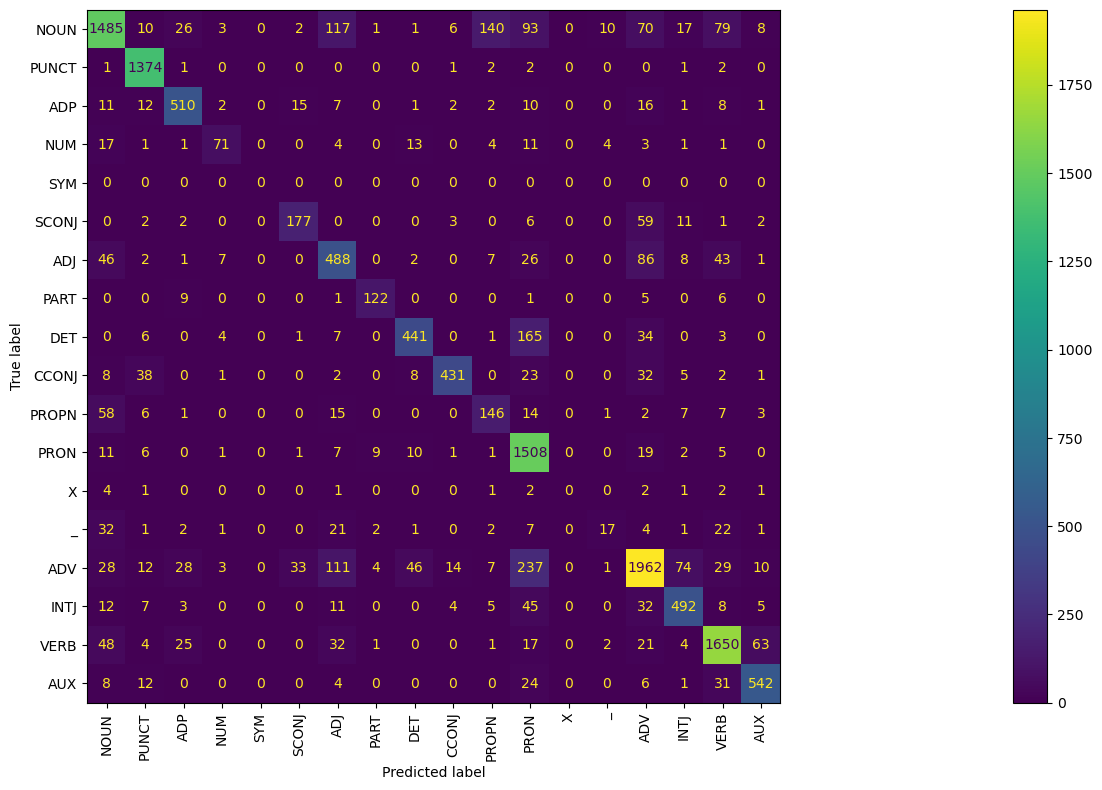

In [52]:
plt.rcParams["figure.figsize"] = (60, 9)

display_metrics(label_mapping=tag_mapping, dl=test_dataloader, model=tag_nn)

## Language Detection

In [53]:
str2idx = {'TR': 0, 'DE': 1, 'OTHER': 2, 'MIXED': 3}
idx2str = {0: 'TR', 1: 'DE', 2: 'OTHER', 3: 'MIXED'}

In [54]:
def tokenize_and_align_codes(examples, label_all_tokens=False, skip_index=-100):
    tokenized_inputs = tokenizer_data(examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=256)
    labels = []


    for i, misc in enumerate(examples["misc"]):
        label = [ast.literal_eval(el).get("LangID", "OTHER") if ast.literal_eval(el) is not None else "OTHER" for el in misc ]
        label = [str2idx.get(l, 2) for l in label]
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids : list[int] = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(skip_index)

            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else skip_index)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [55]:
train_tokenized = train.map(lambda example: tokenize_and_align_codes(example),
                            batched=True, batch_size=BATCH_SIZE)

val_tokenized = val.map(lambda example: tokenize_and_align_codes(example),
                        batched=True, batch_size=BATCH_SIZE)

# Filter as needed for subsequent processing
train_tokenized.set_format(type='torch', columns=list(["input_ids",
                                                       "labels",
                                                       "attention_mask"]))
val_tokenized.set_format(type='torch', columns=list(["input_ids",
                                                     "labels",
                                                     "attention_mask"]))



# Create DataLoaders
train_dataloader = DataLoader(train_tokenized, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_tokenized, batch_size=BATCH_SIZE)

In [56]:
code_nn = POSTagger(4, model,  dim=params["model_params"]["model_dim"]).to(device)

code_logs_ours = train_model(model=code_nn, dataloader_trn=train_dataloader, dataloader_val=val_dataloader)

Validating...: 100%|██████████| 51/51 [04:12<00:00,  4.96s/it]


Train Loss: 8.607288002967834	 Train Accuracy 0.8237119801365611
Val Loss: 17.16598115861416	 Val Accuracy 0.9121046228710462


Validating...: 100%|██████████| 51/51 [04:12<00:00,  4.94s/it]


Train Loss: 3.316464114934206	 Train Accuracy 0.951996689426857
Val Loss: 12.32498012110591	 Val Accuracy 0.9357512165450121


Validating...: 100%|██████████| 51/51 [04:04<00:00,  4.80s/it]


Train Loss: 1.9973966255784035	 Train Accuracy 0.9712393958204014
Val Loss: 11.237319495528936	 Val Accuracy 0.941073600973236


Validating...: 100%|██████████| 51/51 [04:22<00:00,  5.14s/it]


Train Loss: 1.4336046949028969	 Train Accuracy 0.97848127457066
Val Loss: 11.033038213849068	 Val Accuracy 0.9427463503649635


Validating...: 100%|██████████| 51/51 [04:32<00:00,  5.34s/it]

Train Loss: 1.0448915921151638	 Train Accuracy 0.9848955100351748
Val Loss: 12.113077148795128	 Val Accuracy 0.9388686131386861


Macro F1: 0.719
Micro F1: 0.943
Weighted F1: 0.938
Accuracy: 0.943 
F1 Score per POS Tag: 
TR:	0.950
DE:	0.956
OTHER:	0.920
MIXED:	0.050


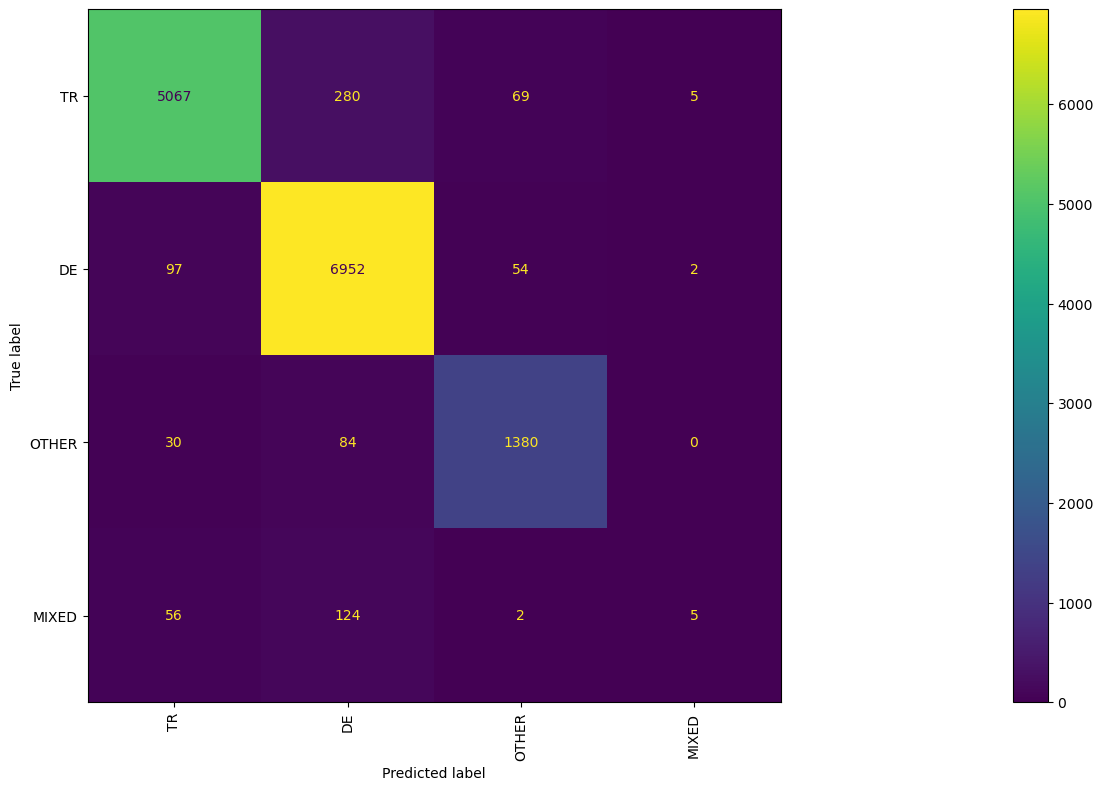

In [57]:
# Tokenize
test_tokenized = test.map(lambda example: tokenize_and_align_codes(example),
                          batched=True, batch_size=BATCH_SIZE)

# Filter as needed for subsequent processing
test_tokenized.set_format(type='torch', columns=list(["input_ids",
                                                      "labels",
                                                      "attention_mask"]))
# Create DataLoaders
test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE)

display_metrics(label_mapping=idx2str, dl=test_dataloader, model=code_nn)

## Masked Language Prediction

In [ ]:
def accuracy_at_n(y_true, y_pred, n=3):
  top_n = torch.topk(y_pred, k=n)[1]
  y_true = y_true.view(-1, 1).to(device)
  correct = (y_true == top_n).any(1)
  return torch.sum(correct) / correct.size(0)

In [59]:
accs3 = []
accs5 = []
accs1 = []
model.eval()
for line in tqdm(test):
    text = line["text"]
    # print(text)
    input_ids =  tokenizer_data(text, add_special_tokens=False, return_tensors="pt", max_length=params["max_len"], truncation=True)["input_ids"]
    mask = torch.eye(input_ids.size(1)).bool().to(device)
    masked_ids = input_ids.repeat(mask.size(1), 1).to(device)
    masked_ids[mask] = tokenizer.mask_token_id
    mask_token_index = torch.where(masked_ids == tokenizer.mask_token_id)[1]
    with torch.no_grad():
        output = model(masked_ids, key_padding_mask=None, pred_mask=torch.flatten(mask))
    pred = output["masked_preds"]
    tok_id = torch.argmax(pred, 1)
    # print(tokenizer_data.decode(tok_id))
    # print("---------")
    acc1 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=1)
    acc3 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=3)
    acc5 = accuracy_at_n(y_true=input_ids, y_pred=pred, n=5)
    accs3.append(acc3)
    accs1.append(acc1)
    accs5.append(acc5)


  0%|          | 0/805 [00:00<?, ?it/s]

100%|██████████| 805/805 [37:06<00:00,  2.77s/it]  


In [61]:
print(sum(accs1) / len(accs1))
print(sum(accs3) / len(accs3))
print(sum(accs5) / len(accs5))

tensor(0.6515)
tensor(0.7795)
tensor(0.8169)


In [94]:
from transformers import AutoModelForMaskedLM

In [95]:
bert_mlm = AutoModelForMaskedLM.from_pretrained(params["tokenizer-model"])
bert_mlm.to(device)
c = 0
total_acc = 0
bert_mlm.eval()
for seq in test:
  tokens = " ".join(seq["tokens"])
  input_ids = tokenizer(tokens, add_special_tokens=False, return_tensors="pt")["input_ids"]
  mask = torch.eye(input_ids.size(1)).bool().to(device)
  masked_ids = input_ids.repeat(mask.size(1), 1).to(device)
  masked_ids[mask] = tokenizer.mask_token_id
  mask_token_index = torch.where(masked_ids == tokenizer.mask_token_id)[1]
  output = bert_mlm(masked_ids).logits
  mask_token_logits = output[0, mask_token_index, :]
  acc = accuracy_at_n(y_true=input_ids, y_pred=mask_token_logits, n=1)
  total_acc += acc
  c += 1

print(f"Average Accuracy: {total_acc/c:.5f}")

KeyboardInterrupt: 